### [2025_12_08]_과제
- 다양한 생선의 품종 식별 모델
- 데이터 : fish.csv
- 데이터 증강 : 160행 => (생선품종별로 갯수 동일하게 맞추기)
                     10K행
- 필수
   * 전처리
   * 타겟과 관련성 높은 피쳐 선택
   * 모델: KNN
   * 교차 검증 진행
   * 예측에 따른 확인 작업 필수

[1] 모듈 로딩 및 데이터 준비 <hr>

In [50]:
## 모듈 로딩
#-> 기본 모듈
import numpy as np
import pandas as pd

#-> 시각화 모듈
import matplotlib.pyplot as plt
import koreanize_matplotlib

#-> ML 관련 모듈
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [51]:
## 훈련 데이터 준비
DATA_FILE = '../Data/fish_train_10500.csv'

df = pd.read_csv(DATA_FILE)
df.Species.unique()

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [52]:
df.Species.value_counts()

Species
Bream        1500
Roach        1500
Whitefish    1500
Parkki       1500
Perch        1500
Pike         1500
Smelt        1500
Name: count, dtype: int64

In [53]:
df.head()

,Weight,Length,Diagonal,Height,Width,Species
0,487.423341,32.423746,37.857082,14.591014,5.270922,Bream
1,990.896538,41.365270,47.308866,18.719116,7.000605,Bream
2,627.081718,33.444702,38.939902,15.463397,5.670238,Bream
3,749.382720,35.686411,41.026632,15.974293,6.036774,Bream
4,615.621949,33.527752,39.005218,15.502285,5.483102,Bream


[2] 데이터 전처리 및 학습 준비 <hr>

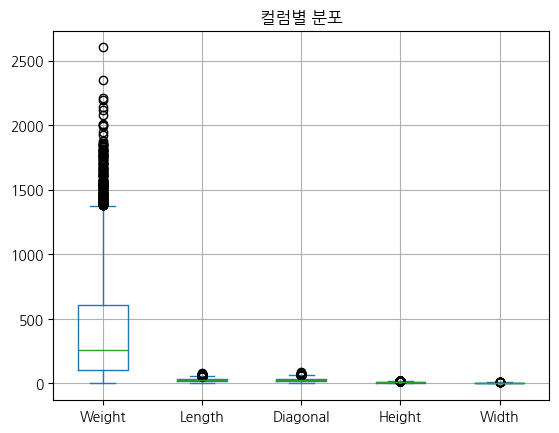

In [54]:
## -----------------------------------------
## 결측치/중복값/이상치
## -----------------------------------------
df.isna().sum()         ## => 0개

df.duplicated().sum()   ## => 0개

df.plot(kind='box', title='컬럼별 분포', grid=True)
plt.show()

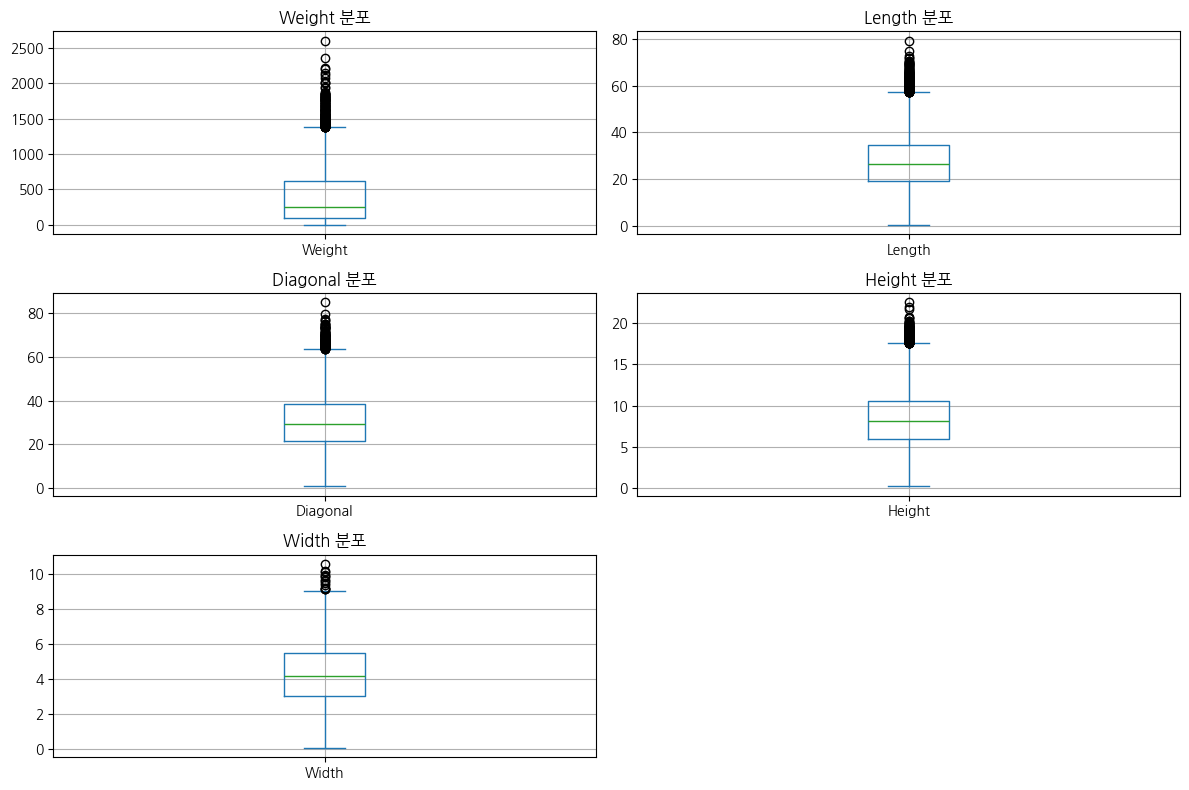

In [55]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

df[['Weight']].plot(kind='box', ax=axes[0, 0], grid=True)
axes[0, 0].set_title('Weight 분포')

df[['Length']].plot(kind='box', ax=axes[0, 1], grid=True)
axes[0, 1].set_title('Length 분포')

df[['Diagonal']].plot(kind='box', ax=axes[1, 0], grid=True)
axes[1, 0].set_title('Diagonal 분포')

df[['Height']].plot(kind='box', ax=axes[1, 1], grid=True)
axes[1, 1].set_title('Height 분포')

df[['Width']].plot(kind='box', ax=axes[2, 0], grid=True)
axes[2, 0].set_title('Width 분포')

axes[2, 1].set_visible(False)  # 마지막 칸 비우기

plt.tight_layout()
plt.show()

In [56]:
## 이상치 제거 함수 만들기
def delete_iqr_df(df, col):
    s = df[col]
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    cond = (s >= q1 - 1.5*iqr) & (s <= q3 + 1.5*iqr)
    return df[cond]  

In [57]:
# 모든 열 이상치 제거하기
for col in ['Weight', 'Length', 'Diagonal', 'Height', 'Width']:
    df = delete_iqr_df(df, col)

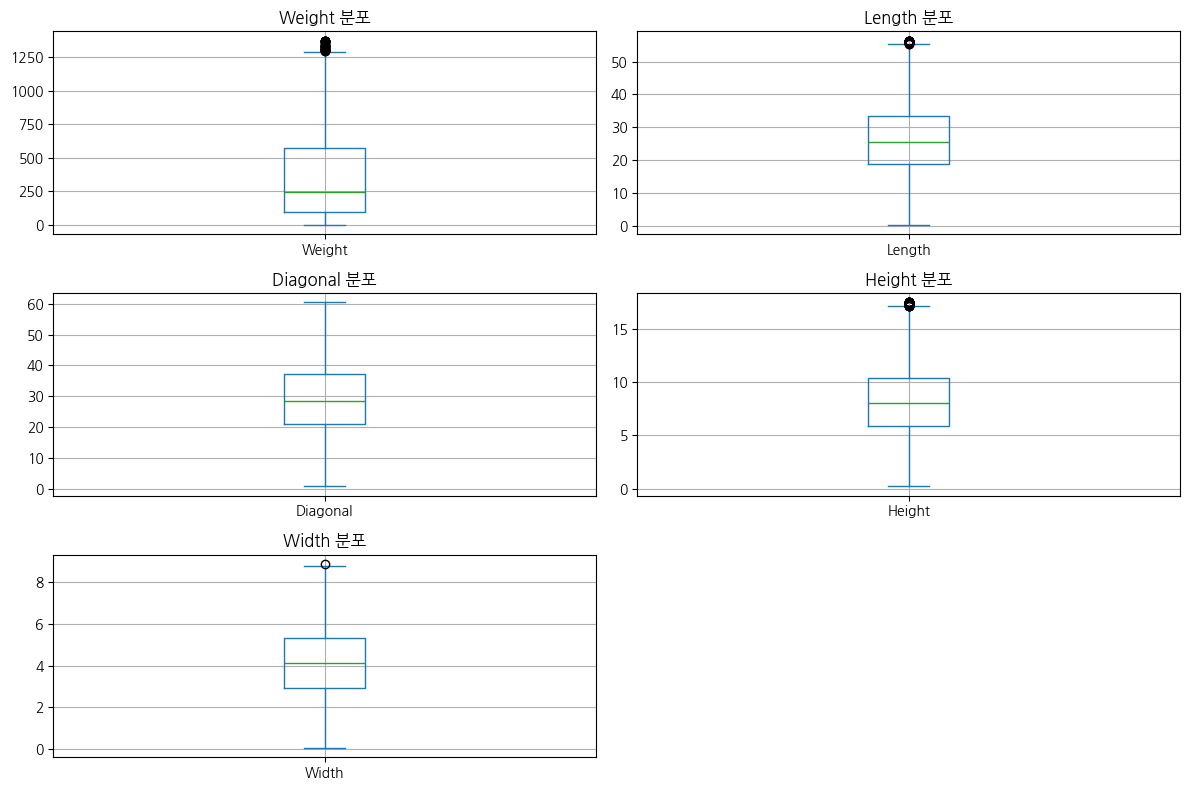

In [58]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

df[['Weight']].plot(kind='box', ax=axes[0, 0], grid=True)
axes[0, 0].set_title('Weight 분포')

df[['Length']].plot(kind='box', ax=axes[0, 1], grid=True)
axes[0, 1].set_title('Length 분포')

df[['Diagonal']].plot(kind='box', ax=axes[1, 0], grid=True)
axes[1, 0].set_title('Diagonal 분포')

df[['Height']].plot(kind='box', ax=axes[1, 1], grid=True)
axes[1, 1].set_title('Height 분포')

df[['Width']].plot(kind='box', ax=axes[2, 0], grid=True)
axes[2, 0].set_title('Width 분포')

axes[2, 1].set_visible(False)  # 마지막 칸 비우기

plt.tight_layout()
plt.show()

In [59]:
df.Species.value_counts()

Species
Roach        1500
Smelt        1500
Parkki       1500
Whitefish    1492
Perch        1485
Bream        1337
Pike         1279
Name: count, dtype: int64

In [61]:
df.corr(numeric_only=True)

,Weight,Length,Diagonal,Height,Width
Weight,1.000000,0.890264,0.891605,0.678975,0.853543
Length,0.890264,1.000000,0.996290,0.637459,0.866834
Diagonal,0.891605,0.996290,1.000000,0.686460,0.877121
Height,0.678975,0.637459,0.686460,1.000000,0.818365
Width,0.853543,0.866834,0.877121,0.818365,1.000000


In [62]:
## [2-1] 품종컬럼 자료형 변환
pd.options.mode.copy_on_write = True

df.Species = df.Species.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10093 entries, 0 to 10499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Weight    10093 non-null  float64 
 1   Length    10093 non-null  float64 
 2   Diagonal  10093 non-null  float64 
 3   Height    10093 non-null  float64 
 4   Width     10093 non-null  float64 
 5   Species   10093 non-null  category
dtypes: category(1), float64(5)
memory usage: 483.3 KB


In [63]:
## [2-2] 피쳐와 타겟분리
featureDF = df[ df.columns[:-1] ]
targetSR  = df[ df.columns[-1]  ]

print(f'featureDF : {featureDF.shape},  targetSR : {targetSR.shape}')

featureDF : (10093, 5),  targetSR : (10093,)


In [64]:
## [2-3] 수치형 컬럼 => KNN 알고리즘 : 스케일링
stdScaler = StandardScaler()
stdScaler.fit(featureDF)

# 스케일링 진행
s_train = stdScaler.transform(featureDF)

[3] 교차검증 <hr>

In [65]:
## 모델 인스턴스 생성
columns_  = ['fit_time', 'score_time', 'test_score', 'train_score', 'neighbors']
resultDF  = pd.DataFrame( columns=columns_ )

for neighbors in range(1, 21):
    kModel = KNeighborsClassifier(n_neighbors=neighbors)

    ## 함수 호출
    resultDict = cross_validate( kModel,
                                 featureDF,
                                 targetSR,
                                 return_train_score=True,
                                 cv=3)
    
    ret = [ resultDict[k].mean().item()  for k in resultDict.keys() ]
    ret.append(neighbors)
    resultDF.loc[resultDF.shape[0]] = ret

In [66]:
resultDF['diff'] = abs(resultDF['test_score'] - resultDF['train_score'])
resultDF.sort_values('diff')

,fit_time,score_time,test_score,train_score,neighbors,diff
19,0.005993,0.013134,0.786486,0.808630,20.0,0.022143
18,0.006450,0.013241,0.788666,0.811602,19.0,0.022936
17,0.007023,0.012667,0.792926,0.817596,18.0,0.024670
16,0.006012,0.012974,0.794611,0.819925,17.0,0.025314
15,0.006753,0.011691,0.798871,0.824730,16.0,0.025859
12,0.006335,0.010677,0.809275,0.836322,13.0,0.027048
14,0.006003,0.011696,0.801447,0.828743,15.0,0.027295
13,0.006356,0.010970,0.807293,0.835084,14.0,0.027791
11,0.005998,0.010669,0.815814,0.845735,12.0,0.029921
10,0.007142,0.010023,0.816706,0.848509,11.0,0.031803


[4] 학습 진행 <hr>

In [ ]:
## [4-1] 모델 인스턴스 생성
kModel = KNeighborsClassifier(n_neighbors=13)
kModel

,n_neighbors,13
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [68]:
## [4-2] 학습 진행
kModel.fit(s_train, targetSR)

,n_neighbors,13
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능평가

In [69]:
train_score = kModel.score(s_train, targetSR)

print(f'학습 점수 : {train_score}')

학습 점수 : 0.9588823937382345


[6] 테스트 셋으로 확인하기 <hr>

In [70]:
## Test 데이터셋 불러오기
DATA_FILE_T = '../Data/fish_test_300.csv'

df_t = pd.read_csv(DATA_FILE_T)

In [71]:
df_t.Species = df_t.Species.astype('category')

tfeatureDF = df_t[ df.columns[:-1] ]
ttargetSR  = df_t[ df.columns[-1]  ]

print(f'tfeatureDF : {tfeatureDF.shape},  ttargetSR : {ttargetSR.shape}')

tfeatureDF : (300, 5),  ttargetSR : (300,)


In [72]:
## 스케일링 진행
s_test = stdScaler.transform(tfeatureDF)

In [73]:
test_score = kModel.score(s_test, ttargetSR)

print(f'테스트 점수 : {test_score}')

테스트 점수 : 0.95
